# Pose estimation

Estimate the position and orientation of a hyperspectral scanner using a dense, georeferenced 3-D point cloud. 

In [3]:
import os
import glob
import numpy as np
from tqdm.auto import tqdm
import utm
import re

In [4]:
import hylite
import hylite.io as io
from hylite.sensors import Fenix
from hylite.project.align import align_to_cloud
from hylite.correct import estimate_sun_vec

## Define data directories

In [3]:
# input directory containing images to locate (these should all be captured from about the same location)
path = '/Users/thiele67/Documents/Data/SPAIN/2020_Sierra_Bullones/20200309_sun/Tharsis_smallpit_0068__3_3m00_4m00'
image_paths = glob.glob( os.path.join(path,"*.hdr"), recursive=True )

In [4]:
# path to point cloud to georeference against
cloud_path = '/Users/thiele67/Documents/Data/CA/CA_50cm_coregistered.ply'

In [5]:
print("Found %d images:" % len(image_paths))
for p in image_paths:
    print(p)

Found 5 images:
/Users/thiele67/Documents/Data/CA/Terrestrial/2019/Corta_Atalaya__85_0m00_2m00_0079.hdr
/Users/thiele67/Documents/Data/CA/Terrestrial/2019/Corta_Atalaya__86_0m00_2m00_0080.hdr
/Users/thiele67/Documents/Data/CA/Terrestrial/2019/Corta_Atalaya__88_0m00_2m00_0082.hdr
/Users/thiele67/Documents/Data/CA/Terrestrial/2019/Corta_Atalaya__84_0m00_2m00_0078.hdr
/Users/thiele67/Documents/Data/CA/Terrestrial/2019/Corta_Atalaya__87_0m00_2m00_0081.hdr


## Define initial camera estimate

In [6]:
pos = [
    
    np.array([711563.227,4175343.356,353.202]),
    np.array([711563.227,4175343.356,353.202]),
    np.array([711563.227,4175343.356,353.202]),
    np.array([711563.227,4175343.356,353.202]),
    np.array([711563.227,4175343.356,353.202]),
    # add more estimated positions as need be
    
]

ori = [
    
    np.array([-89.907,-55.312,1.481]),
    np.array([-89.907,-55.312,1.481]),
    np.array([-89.907,-55.312,1.481]),
    np.array([-89.907,-55.312,1.481]),
    np.array([-89.907,-55.312,1.481]),
    # add more orientation estimates as need be
]

assert len(ori) == len(pos) and len(pos) == len(image_paths), \
        "Error - position and orientation estimates must be specified for each image."

cameras = []
for i,p in enumerate(pos):
    cam = Fenix.get_camera()
    cam.pos = p # camera position
    cam.ori = ori[i] # camera orientation (as euler rotations)
    cameras.append(cam)

In [7]:
utm_zone = 29,'N' # utm zone - used to calculate sun vector (for topo correction)

## Load point cloud and check initial camera estimate is reasonable

In [8]:
cloud = io.loadCloudPLY( cloud_path )

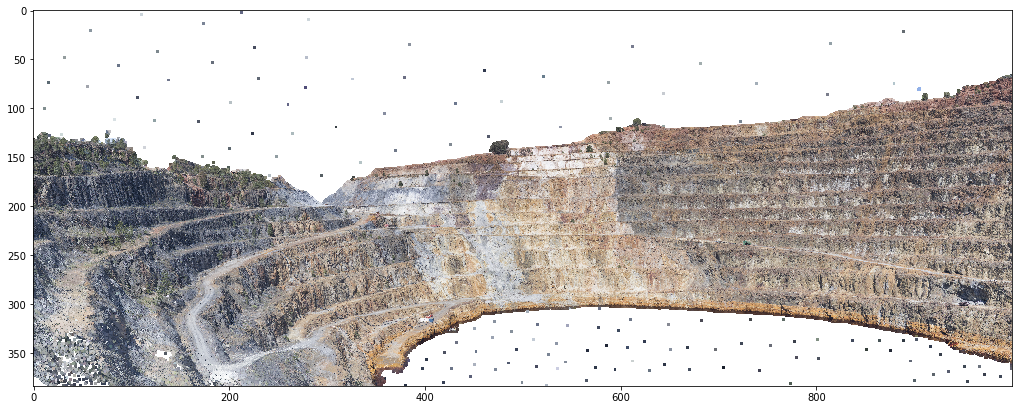

In [9]:
n = 0 # index of image to generate preview for
cameras[n].dims=(1000, cameras[n].dims[1]) # set preview render size
fig,ax = cloud.quick_plot( cameras[n] ) # render preview

## Run computer magics ㋡

In [ ]:
recurse = 2 # repeate alignment twice to improve matching (set to 1 if initial locations are accurate).
recalculate = False # recalculate images that have already been aligned. Otherwise existing camera data are used. 



Aligning image /Users/thiele67/Documents/Data/CA/Terrestrial/2019/Corta_Atalaya__85_0m00_2m00_0079.hdr
Projecting scene... Done.
Gathering matches....r=258....g=298....b=275..(831).
Solved PnP problem using 763 inliers (residual error = 1.0 px).
------------resolving using updated camera transform------------
Projecting scene... Done.
Gathering matches....r=429....g=461....b=437..(1327).
Solved PnP problem using 1274 inliers (residual error = 1.1 px).


Aligning image /Users/thiele67/Documents/Data/CA/Terrestrial/2019/Corta_Atalaya__86_0m00_2m00_0080.hdr
Projecting scene... Done.
Gathering matches....r=278....g=300....b=279..(857).
Solved PnP problem using 825 inliers (residual error = 1.1 px).
------------resolving using updated camera transform------------
Projecting scene... Done.
Gathering matches....r=454....g=459....b=432..(1345).
Solved PnP problem using 1190 inliers (residual error = 1.1 px).


Aligning image /Users/thiele67/Documents/Data/CA/Terrestrial/2019/Corta_Atalaya__8

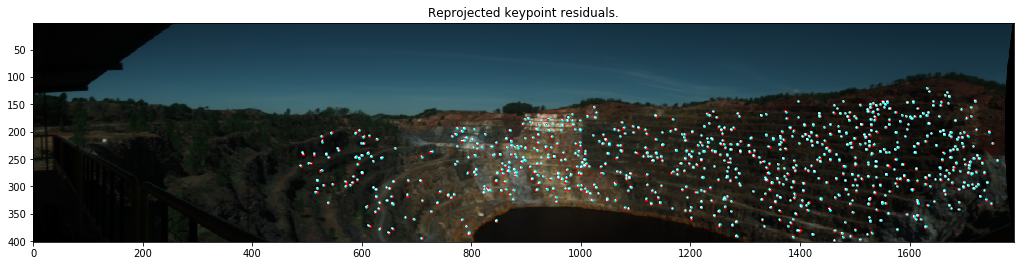

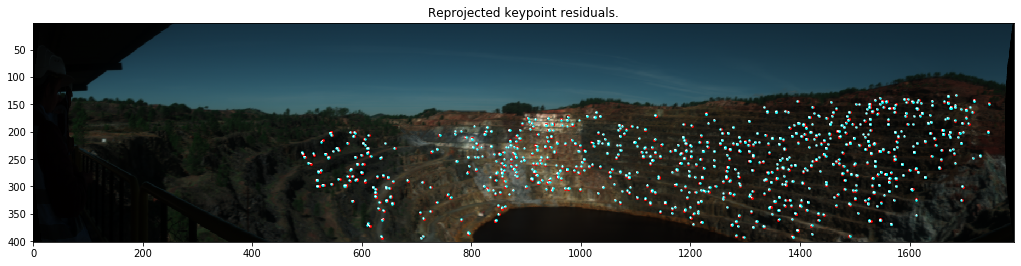

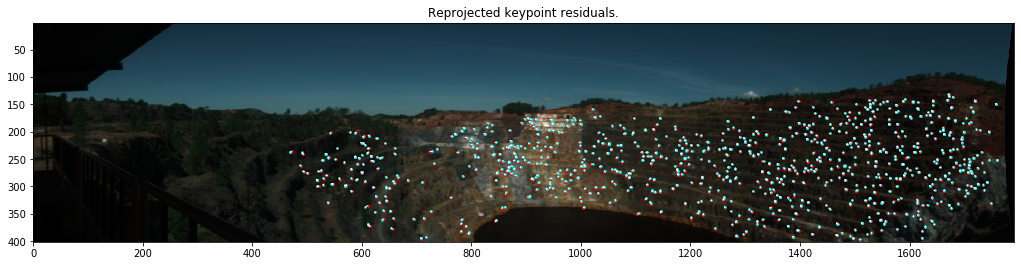

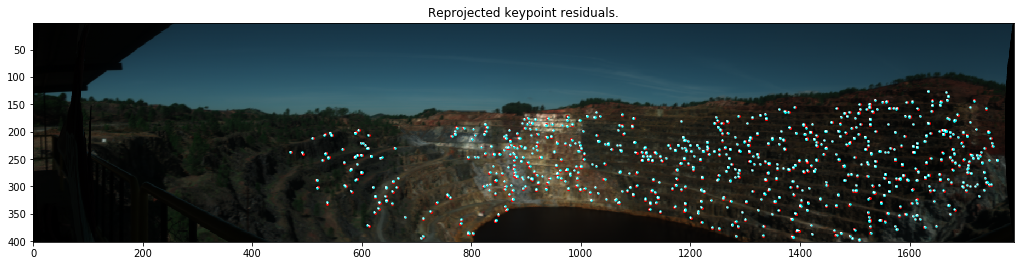

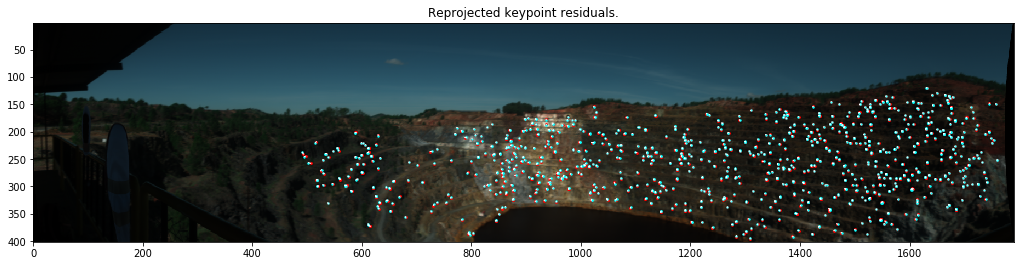

In [16]:
for i,p in enumerate(tqdm(image_paths)):

    image = io.loadWithGDAL( p ) #load image
    cam_est = image.header.get_camera() # look for stored camera
    
    if cam_est is None or recalculate: # image needs to be aligned
        print("\n\nAligning image %s" % p)


        cam = cameras[i]
        cam.dims = (image.xdim(), image.ydim()) # make sure camera dimensions exactly match image

        #estimate position
        cam_est, kp, e = align_to_cloud(image, cloud, cam, recurse=recurse)

        if cam_est is None:
            print("Error - failed to align camera %s")
            #continue # UNCOMMENT THIS LINE TO IGNORE NON-ALIGNED CAMERAS
            assert False, "Error - failed to align camera %s" % p 
    else: # image has already been aligned. Use this info instead. 
        print("\n\nUsing stored pose for %s" % p)
    
    #store camera location in image header
    image.header.set_camera(cam_est)
    
    #add utm zone and estimated sun vector to header
    image.header['utm Zone'] = "%d %s" % utm_zone
    lat,lon = utm.to_latlon( cam_est.pos[0], cam_est.pos[1], 
                             utm_zone[0], utm_zone[1] )

    # UNCOMMENT THESE LINES TO FORCE TIME AND DATE
    #image.header['start time'] = 'UTC TIME: 11:15:00' # Time must be in UTC
    #image.header['acquisition date'] = 'DATE(yyyy-mm-dd): 2019-04-17'
    if 'start time' in image.header \
            and 'acquisition date' in image.header:

        #get time
        start = re.findall(r'\d{2}:\d{2}:\d{2}', image.header['start time'])[0]
        date = re.findall(r'\d{4}-\d{2}-\d{2}', image.header['acquisition date'])[0]
        time = ('%s %s' % (date, start), '%Y-%m-%d %H:%M:%S', 'UTC')
        sunvec, az, el = estimate_sun_vec( lat, lon, time)

        #store in header
        image.header['sun azimuth'] = '%d' % az
        image.header['sun elevation'] = '%d' % el
        
    #and save it
    outpath = io.matchHeader(p)[0]
    io.saveHeader(outpath, image.header)